In [10]:
import os
import pickle
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential, layers
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

In [2]:
tf.__version__

'2.0.0'

In [11]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], False)

In [12]:
model_name = 'SHIT-Net_v3'

In [16]:
home = os.path.expanduser('~')
base = os.path.join('Datasets', 'ImageCLEF', 'Slice_Masks_331')

train_dir = os.path.join(home, base, 'train')
test_dir = os.path.join(home, base, 'test')


In [17]:
seed = 42
shuffle = True
#inp_shp = (331, 331)
inp_shp = (224,224)
train_batch_size, val_batch_size = 16, 64

train_datagen = keras.preprocessing.image.ImageDataGenerator(
                    rescale=1./255,
                    horizontal_flip=True
)

val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=inp_shp,
        batch_size=train_batch_size,
        seed=seed,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=shuffle
)

val_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=inp_shp,
        batch_size=val_batch_size,
        seed=seed,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=shuffle
)

Found 59888 images belonging to 5 classes.
Found 14847 images belonging to 5 classes.


In [7]:
input_shape = (300, 300,3)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=input_shape, num_classes=5)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 150, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 150, 150, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:

model.compile(
    optimizer="Adam", 
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [9]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    f"{model_name}.h5", save_best_only=True
)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="accuracy", patience=64)


history = model.fit(
            train_generator,
            epochs=16,
            steps_per_epoch = 450,
            validation_data=val_generator,
            validation_steps=200,
            shuffle=False)
#             callbacks=[checkpoint_cb, early_stopping_cb]

Train for 450 steps, validate for 200 steps
Epoch 1/16
450/450 [==============================] - 287s 637ms/step - loss: 1.4252 - accuracy: 0.4525 - val_loss: 2.3038 - val_accuracy: 0.1163
Epoch 2/16
450/450 [==============================] - 253s 562ms/step - loss: 1.3591 - accuracy: 0.4721 - val_loss: 14.0709 - val_accuracy: 0.1163
Epoch 3/16
450/450 [==============================] - 205s 455ms/step - loss: 1.3392 - accuracy: 0.4767 - val_loss: 52.2393 - val_accuracy: 0.1163
Epoch 4/16
 25/450 [>.............................] - ETA: 1:56 - loss: 1.2764 - accuracy: 0.5312

KeyboardInterrupt: 

In [18]:
input_shape=(224,224,3)
ResNet50 = tf.keras.applications.ResNet50V2(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None
)
ResNet50.trainable = False

In [25]:
def get_model(base_model, input_shape):
    
    inputs = keras.Input(shape=input_shape)
    x = keras.applications.nasnet.preprocess_input(inputs)
    y = base_model(x, training=False)
    
    z = layers.MaxPooling2D(pool_size=(3, 3))(y)
    
    x = layers.Conv2D(128, (2, 2), activation=None)(y)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
#     x = layers.Dropout(rate=0.5)(x)
#     x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(256, (2, 2), activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
#     x = layers.Dropout(rate=0.5)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Concatenate(axis=3)([x, z])
#     x = layers.Conv2D(32, (3, 3), activation=None)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.LeakyReLU(alpha=0.1)(x)
#     x = layers.Dropout(rate=0.5)(x)
#     x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Flatten()(x)
    
    x = layers.Dense(units=64, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    y = layers.Dropout(rate=0.25)(x)

    x = layers.Dense(units=16, activation=None)(y)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(rate=0.25)(x)
    
    x = layers.Concatenate(axis=1)([x, y])
    
    x = layers.Dense(units=5, activation=None)(x)
    output = layers.Softmax()(x)

    model = keras.Model(inputs=inputs, outputs=output, name=f'{model_name}')
    
    return model
#     model.compile(optimizer="Adam", loss="mse", metrics=["mae"])


In [26]:
model = get_model(ResNet50, input_shape)
model.summary()

Model: "RestNet50-V2_Axial_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 224, 224, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_1 (TensorFlowOp [(None, 224, 224, 3) 0           tf_op_layer_truediv_1[0][0]      
__________________________________________________________________________________________________
resnet50v2 (Model)              (None, 7, 7, 2048)   23564800    tf_op_layer_sub_1[0][0]          
______________________________________________________________________________

In [31]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=1e-4),
    metrics=["accuracy"],
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8)

model_name = "RestNet50-V2_Axial_SkipCon_v1"
# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    f"{model_name}.h5", save_best_only=True
)
history = model.fit(
            train_generator,
            epochs=1,
            steps_per_epoch=591,
            validation_data=val_generator,
            validation_steps=100,
            shuffle=False,
            callbacks=[checkpoint_cb, early_stopping_cb]
)

Train for 591 steps, validate for 100 steps
591/591 [==============================] - 113s 191ms/step - loss: 1.3951 - accuracy: 0.4600 - val_loss: 2.6893 - val_accuracy: 0.4669


In [120]:
to_res = (224, 224)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Lambda(lambda image: tf.image.resize(image, to_res)))
model.add(res_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(5, activation='softmax'))

In [123]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)



In [124]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    f"{model_name}.h5", save_best_only=True
)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=64)

history = model.fit(
            train_generator,
            epochs=64,
            validation_data=val_generator,
            validation_steps=1,
            shuffle=False,
#             callbacks=[checkpoint_cb, early_stopping_cb]
)

Train for 46 steps, validate for 1 steps
Epoch 1/64
46/46 [==============================] - 17s 361ms/step - loss: 1.3224 - accuracy: 0.4665 - val_loss: 1.3711 - val_accuracy: 0.4844
Epoch 2/64
46/46 [==============================] - 8s 185ms/step - loss: 1.3398 - accuracy: 0.4542 - val_loss: 1.3687 - val_accuracy: 0.4844
Epoch 3/64
46/46 [==============================] - 8s 184ms/step - loss: 1.3234 - accuracy: 0.4501 - val_loss: 1.3694 - val_accuracy: 0.4844
Epoch 4/64
46/46 [==============================] - 8s 183ms/step - loss: 1.3146 - accuracy: 0.4624 - val_loss: 1.3704 - val_accuracy: 0.4844
Epoch 5/64
46/46 [==============================] - 8s 183ms/step - loss: 1.3190 - accuracy: 0.4788 - val_loss: 1.3719 - val_accuracy: 0.4844
Epoch 6/64
46/46 [==============================] - 8s 185ms/step - loss: 1.3222 - accuracy: 0.4651 - val_loss: 1.3705 - val_accuracy: 0.4844
Epoch 7/64
46/46 [==============================] - 8s 185ms/step - loss: 1.3390 - accuracy: 0.4460 - val_

46/46 [==============================] - 9s 187ms/step - loss: 1.2849 - accuracy: 0.4815 - val_loss: 1.3722 - val_accuracy: 0.4844
Epoch 59/64
46/46 [==============================] - 9s 185ms/step - loss: 1.3059 - accuracy: 0.4651 - val_loss: 1.3723 - val_accuracy: 0.4844
Epoch 60/64
46/46 [==============================] - 9s 185ms/step - loss: 1.2866 - accuracy: 0.4925 - val_loss: 1.3733 - val_accuracy: 0.4844
Epoch 61/64
46/46 [==============================] - 9s 187ms/step - loss: 1.2564 - accuracy: 0.4706 - val_loss: 1.3725 - val_accuracy: 0.4844
Epoch 62/64
46/46 [==============================] - 8s 183ms/step - loss: 1.2836 - accuracy: 0.4829 - val_loss: 1.3721 - val_accuracy: 0.4844
Epoch 63/64
46/46 [==============================] - 8s 185ms/step - loss: 1.3101 - accuracy: 0.4637 - val_loss: 1.3732 - val_accuracy: 0.4844
Epoch 64/64
46/46 [==============================] - 9s 187ms/step - loss: 1.2833 - accuracy: 0.4761 - val_loss: 1.3731 - val_accuracy: 0.4844


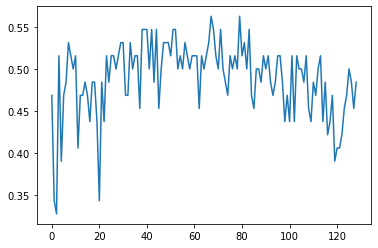

In [20]:
plt.plot(history.history['val_accuracy'])

In [29]:
np.max(history.history['val_accuracy'])

0.4684375

In [34]:
model_load = keras.models.load_model('RestNet50-V2_Axial_SkipCon_v1.h5')

In [35]:
model_load.evaluate(val_generator)

232/232 [==============================] - 86s 370ms/step - loss: 2.6685 - accuracy: 0.4695


[2.6685405275945007, 0.46945512]

In [11]:
with open(f'{model_name}_history.pkl', 'wb') as fh:
    pickle.dump(history.history, fh)